# modeling

The goal of this notebook will be to find an appropriate model to move forward with.  Because this is a general immage classification problem, accuracy will be the success metric used.  There is no reason to prefer misclassification in any direction and enough new images were generated to ensure that each of the 5 classes are well balanced.  An accuracy score of 90+ on the test dataset will be considered a success.

## contents
* [imports and settings](#imports)
* [cnn trained with collected data](#cnn)
* [resnet50 pretrained](#resnet50)

## imports and settings<a id='imports'></a>

In [1]:
import os
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D

warnings.filterwarnings("ignore")
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-10 14:32:05.921403: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 14:32:05.941021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 14:32:05.941044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 14:32:05.941548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 14:32:05.945006: I tensorflow/core/platform/cpu_feature_guar

## cnn trained with collected data<a id='cnn'></a>

The first model I will try is a convulutional neural network trained with only the images I have collected.  The first step will be to establish the train and validate sets and setup the generators for TensorFlow.

In [2]:
batch_size = 50 
img_size = (256, 256)

train_dir = '../data/splits/train'
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_dir = '../data/splits/validate'  
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=50,
    class_mode='categorical'
)

Found 4999 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


The next step is to define the model in terms of layers.  Each of these selections was arbitrary, a best effort guess at what would give good results.

In [3]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

2023-12-10 14:32:06.814692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 14:32:06.814799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 14:32:06.814843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Now, we train the model.

In [4]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size  
)

Epoch 1/10


2023-12-10 14:32:07.564204: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-10 14:32:07.604034: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 14:32:07.906320: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 14:32:08.207104: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa2f4d2c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 14:32:08.207121: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-12-10 14:32:08.210107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702240328.251880  649627 device_compiler.

99/99 [==============================] - 8s 53ms/step - loss: 1.5931 - accuracy: 0.2564 - val_loss: 1.4760 - val_accuracy: 0.3960
Epoch 2/10
99/99 [==============================] - 5s 46ms/step - loss: 1.4156 - accuracy: 0.4084 - val_loss: 1.0972 - val_accuracy: 0.6120
Epoch 3/10
99/99 [==============================] - 5s 46ms/step - loss: 1.1086 - accuracy: 0.5765 - val_loss: 0.7171 - val_accuracy: 0.7540
Epoch 4/10
99/99 [==============================] - 5s 46ms/step - loss: 0.8915 - accuracy: 0.6678 - val_loss: 0.7293 - val_accuracy: 0.7340
Epoch 5/10
99/99 [==============================] - 5s 46ms/step - loss: 0.7241 - accuracy: 0.7319 - val_loss: 0.5339 - val_accuracy: 0.7960
Epoch 6/10
99/99 [==============================] - 5s 46ms/step - loss: 0.5825 - accuracy: 0.7866 - val_loss: 0.6229 - val_accuracy: 0.8120
Epoch 7/10
99/99 [==============================] - 5s 46ms/step - loss: 0.4695 - accuracy: 0.8323 - val_loss: 0.5742 - val_accuracy: 0.8080
Epoch 8/10
99/99 [======

86% accuracy on the validation set seems promising, but the validation loss is high, indicating we might be overfitting early.  Before looking at the test data, let's plot the loss.

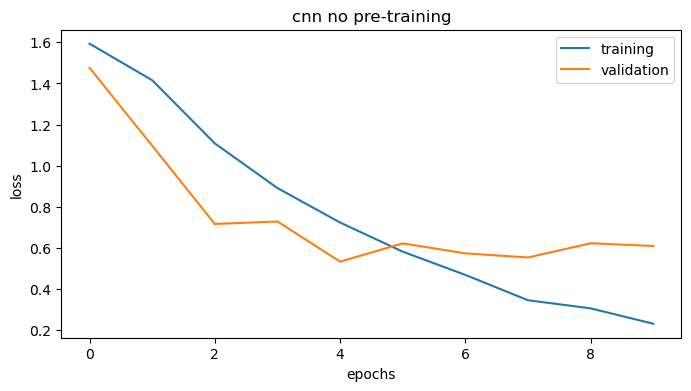

In [5]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

plt.title('cnn no pre-training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

The model converged the best it could early and the loss was still over 0.5 on the validation set when it did.  It seems like we may need more images to be able to train a more accurate model.  As it would be difficult to get new images, maybe using a pre-trained model would give better results?

## Pre-trained with ResNet50<a id='resnet50'></a>

The ResNet50 model included with TensorFlow is a good candidate for pre-training an image classifier.  I will start with it by first defining the model.

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Then creating the generators for the train, validate and test datasets and finally traning the model.  

In [7]:
# Define directories
train_dir = '../data/splits/train'
val_dir = '../data/splits/validate'
test_dir = '../data/splits/test'

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    # Add any other preprocessing here
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Flow from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

Found 4999 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/10
157/157 [==============================] - 9s 45ms/step - loss: 0.4776 - accuracy: 0.8296 - val_loss: 0.1812 - val_accuracy: 0.9440
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1336 - accuracy: 0.9624 - val_loss: 0.1601 - val_accuracy: 0.9480
Epoch 3/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0791 - accuracy: 0.9810 - val_loss: 0.1486 - val_accuracy: 0.9580
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0488 - accuracy: 0.9898 - val_loss: 0.1396 - val_accuracy: 0.9520
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0300 - accuracy: 0.9962 - val_loss: 0.1282 - val_accuracy: 0.9580
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.0197 - accuracy: 0.9982 - val_loss: 0.1289 - val_accuracy: 0.9660
Epoch 7/10
157/157

96% accuracy with a 0.137 loss represents a much stronger model that should generalize well going forward.  This has met my success criteria and this model will be the one to move forward.  Just to confirm, let's look at the loss in the same way.

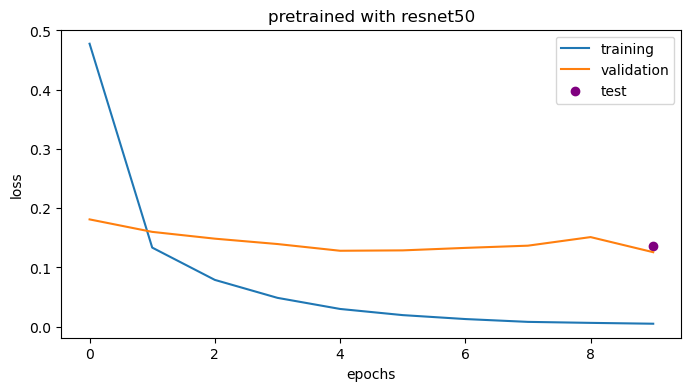

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.scatter(len(history.history['loss']) - 1, test_loss, label='test', color='purple')

plt.title('pretrained with resnet50')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [9]:
model.save(os.path.join('../models','resnet50_pretrained.h5'))